In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get data for all Test matches (March 8, 2004 - January 3, 2022) - compiled together from Cricsheet
data = pd.read_csv('all_matches.csv')

In [3]:
# Set the desired player's info
player = 'SN Thakur'
player_short_name = 'Thakur'
player_debut = '2018-10-12'
team_desc = 'Indian'

# Filter and sort the data
data = data[data['start_date'] >= player_debut]
data = data.sort_values(['start_date', 'innings', 'ball'])

# Combine the runs scored off the bat with the extras for partnership calculations
data['runs'] = data['runs_off_bat'] + data['extras']

In [4]:
# Return each innings after calculating the partnerships
def get_partnerships(innings):
    wicket_condition = ((~innings['player_dismissed'].isnull()) & 
                        (~innings['wicket_type'].isin(['retired hurt', 'retired not out']))).shift(fill_value = False).cumsum()
    innings['partnership'] = innings.groupby(wicket_condition)['runs'].cumsum()
    return innings

# Calculate the cumulative partnerships for each innings in each match
data = data.groupby(['match_id', 'innings']).apply(get_partnerships)

In [5]:
# Get all dismissals excluding run out, retired hurt, and retired not out
dismissals = data[(~data['player_dismissed'].isnull()) & 
                  (~data['wicket_type'].isin(['run out', 'retired hurt', 'retired not out']))]

# Calculate the total partnership runs and wickets taken for each bowler
bowling_summary = dismissals.groupby(['bowler', 'bowling_team'])['partnership'].agg(partnership_runs = 'sum', wickets = 'count').reset_index()
bowling_summary['avg_partnership_broken'] = (bowling_summary['partnership_runs'] / bowling_summary['wickets']).round(2)
filtered_bowling_summary = bowling_summary[bowling_summary['wickets'] > 15].reset_index(drop = True)

# Display the bowling summary for a team
team_bowling_data = filtered_bowling_summary[filtered_bowling_summary['bowling_team'] == 'India'].reset_index()
team_bowling_data[['bowler', 'wickets', 'avg_partnership_broken']]

,bowler,wickets,avg_partnership_broken
0,AR Patel,36,12.36
1,I Sharma,55,20.95
2,JJ Bumrah,79,23.63
3,Mohammed Shami,78,22.46
4,Mohammed Siraj,36,26.78
5,R Ashwin,97,23.52
6,RA Jadeja,50,21.60
7,SN Thakur,24,34.96
8,UT Yadav,49,22.55


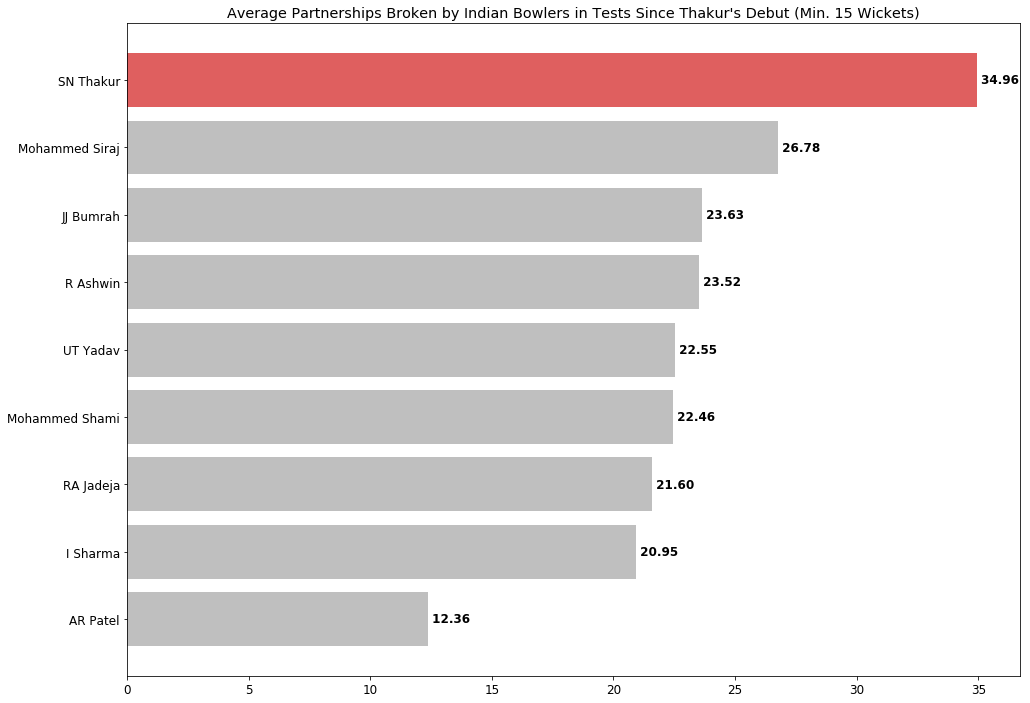

In [6]:
# Set up the plot
plt.figure(figsize = (16, 12))
plt.rcParams.update({'font.size': 12})
plt.title('Average Partnerships Broken by ' + team_desc  + ' Bowlers in Tests Since ' + player_short_name + "'s Debut (Min. 15 Wickets)")

# PLot a horizontal bar chart that represents the bowling summary data for the team
team_bowling_data = team_bowling_data.sort_values('avg_partnership_broken')
plt.barh(team_bowling_data['bowler'], width = team_bowling_data['avg_partnership_broken'], color = 'grey', alpha = 0.5)
plt.barh(player, width = team_bowling_data[team_bowling_data['bowler'] == player]['avg_partnership_broken'], color = 'red', alpha = 0.5)

# Add value labels for each bar
for x, y in enumerate(team_bowling_data['avg_partnership_broken']):
    plt.text(y, x, ' ' + '{:.2f}'.format(y), va = 'center', fontweight = 'bold')
    
# Display the plot
plt.show()